# Denoising U-Net

Архитектура  Denoising U-Net представлена на картинке ниже. Это уже знакомый нам из лекции по сегментации U-Net с привычными skip connections между картами признаков энкодера и декодера (рыжие стрелки и надпись concatenate). На входе сети — зашумленное изображение, на выходе — предсказанный шум.

В качестве базового блока используются ResNet блоки. Из архитектурных добавлений:
- блоки Self-Attention,
- примешивание эмбеддинга текущего шага генерации $t$ при каждом изменении размера.

<center><img src ="https://ml.gan4x4.ru/msu/additions/L13/denoising_unet_architecture.png" width="800"></center>


<center><em>Архитектура Denoising U-Net</em></center>

<center><em>Source: <a href="https://learnopencv.com/denoising-diffusion-probabilistic-models/">
An In-Depth Guide to Denoising Diffusion Probabilistic Models – From Theory to Implementation</a></em></center>

## Базовый блок

В качестве базового блока используются ResNet блоки с GELU в качестве функции активации и GroupNorm.

<center><img src ="https://ml.gan4x4.ru/msu/additions/L13/resnet_block.png" width="800"></center>

In [16]:
import torch.nn as nn
import torch.nn.functional as F


class ResNetBlock(nn.Module):
    def __init__(self, in_features, out_features, mid_features=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_features:
            mid_features = out_features
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_features, mid_features, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_features),
            nn.GELU(),
            nn.Conv2d(mid_features, out_features, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_features),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.conv_stack(x))
        else:
            return self.conv_stack(x)

## Понижение и повышение размерности

При повышении и понижении размерности к картам признаков примешивается информация о текущем шаге зашумления/расшумления. Это делается через “аппендикс” c линейным слоем, который изменяет размер эмбеддинга до количества каналов карты признаков $C_{out}$ и суммирует эмбеддинг с каналами.

Понижение размерности:

<center><img src ="https://ml.gan4x4.ru/msu/additions/L13/down_block.png" width="700"></center>

Повышение размерности — не забываем конкатенировать признаки с энкодера:

<center><img src ="https://ml.gan4x4.ru/msu/additions/L13/upblock.png" width="900"></center>

In [17]:
class ResizeBlock(nn.Module):
    def __init__(self, in_features, out_features, emb_dim):
        super().__init__()
        # defines non-linear map from time embedding features to conv features
        self.emb_projection = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_features),
        )

    def add_emb(self, x, t_vector):
        # [batch_size, time_embedding_dim] -> [batch_size, out_features]
        emb = self.emb_projection(t_vector)
        # [batch_size, out_features] - > [batch_size, out_features, H, W]
        emb = emb[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

    def forward(self, x):
        pass


class Down(ResizeBlock):
    def __init__(self, in_features, out_features, emb_dim=256):
        super().__init__(in_features, out_features, emb_dim)
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ResNetBlock(in_features, in_features, residual=True),
            ResNetBlock(in_features, out_features),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        x = self.add_emb(x, t)
        return x


class Up(ResizeBlock):
    def __init__(self, in_features, out_features, emb_dim=256):
        super().__init__(in_features, out_features, emb_dim)

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            ResNetBlock(in_features, in_features, residual=True),
            ResNetBlock(in_features, out_features, in_features // 2),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        x = self.add_emb(x, t)
        return x

## Self-Attention

Стоит обратить внимание на то, что блок Self-Attention применяется к изображению попиксельно. Именно для этого карты признаков с размерами H×W вытягиваются в векторы HW. Это связано с тем, что пиксели шума, добавляемого к изображению, не коррелированны. Self-Attention — самая вычислительно тяжелая часть модели.

<center><img src ="https://ml.gan4x4.ru/msu/additions/L13/se_block.png" width="900"></center>

In [19]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super().__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, num_heads=4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.mlp = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        # [batch_size, C, H, W] -> [batch_size, H*W, C]
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        # K, Q, V in Self attention are equal
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        # skip connection
        attention_value = attention_value + x
        # simple multilayer perceptron and second skip connection
        attention_value = self.mlp(attention_value) + attention_value
        # back to [batch_size, C, H, W]
        return attention_value.swapaxes(2, 1).view(
            -1, self.channels, self.size, self.size
        )

## Полная архитектура

<center><img src ="https://ml.gan4x4.ru/msu/additions/L13/denoising_unet_architecture.png" width="800"></center>

<center><em>Архитектура Denoising U-Net</em></center>

<center><em>Source: <a href="https://learnopencv.com/denoising-diffusion-probabilistic-models/">
An In-Depth Guide to Denoising Diffusion Probabilistic Models – From Theory to Implementation</a></em></center>

Соберем модель. У нас будут небольшие изображения 64×64, поэтому будет всего 3 понижения/повышения размерности:

In [20]:
class UNet(nn.Module):
    r"""
    Denoising U-Net model implementation based on arXiv:2006.11239 [cs.LG]
    """

    def __init__(self, num_channels=3, img_size=64, time_embed_dim=256):
        super().__init__()
        self.num_channels = num_channels
        self.time_dim = time_embed_dim
        self.img_size = img_size

        # Downsample and enlarge feature dim
        self.inc = ResNetBlock(num_channels, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, img_size // 2)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, img_size // 4)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, img_size // 8)

        # Keep spatial dim constant
        self.conv_bottleneck = nn.Sequential(
            ResNetBlock(256, 512),
            SelfAttention(512, img_size // 8),
            ResNetBlock(512, 256),
        )

        # Upsample and reduce feature dim
        # 512=256+256 from conv_bottleneck and sa3
        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, img_size // 4)
        # 256=128+128 from sa4 and sa2
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, img_size // 2)
        # 128=64+64 from sa5 and sa1
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, img_size)
        self.outc = nn.Conv2d(64, num_channels, kernel_size=1)

    def pos_encoding(self, t):
        r"""
        Returns embedding vector for given integer time index.

        We adopt 1d Positional Encoding form arXiv:1706.03762 [cs.CL]
        see 3.5 for more details.

        PE(x,2i) = sin(x/10000^(2i/D))
        PE(x,2i+1) = cos(x/10000^(2i/D))

        Where:
        x is a point in 1d space
        i is an integer in [0, D/2), where D is the size of the feature dimension

        Args:
            t: Tensor, shape ``[batch_size, 1]``
        Returns:
            pe: Tensor, shape ``[batch_size, time_embedding_dim]``
        """
        # placeholder for diffusion time encoding vector
        pe = torch.zeros(t.shape[0], self.time_dim).to(t.device)

        # factor 1/10000^(2i/D)
        div_factors = torch.exp(
            torch.arange(0, self.time_dim, 2)
            * (-torch.log(torch.as_tensor(10000.0)) / self.time_dim)
        ).to(t.device)

        pe[:, 0::2] = torch.sin(t * div_factors)
        pe[:, 1::2] = torch.cos(t * div_factors)

        return pe

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float).to(x)
        t = self.pos_encoding(t)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.conv_bottleneck(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

В качестве позиционного эмбеддинга используется sin-cos позиционный эмбеддинг из трансформеров.

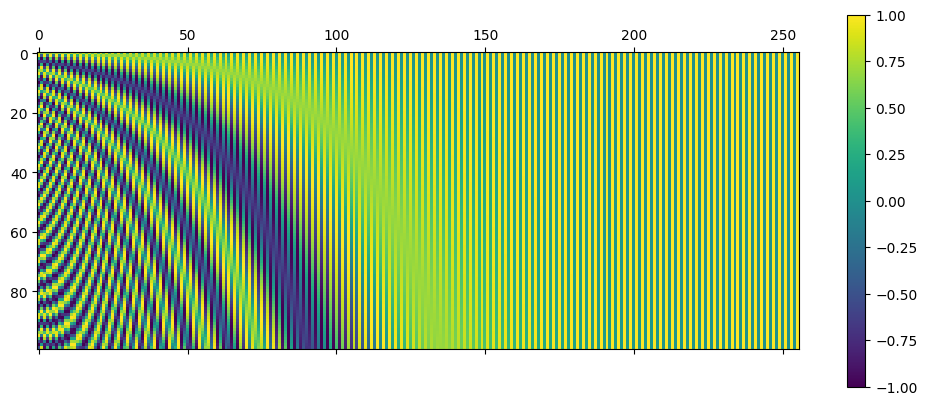

In [5]:
import torch
import matplotlib.pyplot as plt

num_noise_steps = 1000
time_embed_dim = 256

model = UNet()

t = torch.arange(start=1, end=1001, step=1).unsqueeze(1)
positional_embeding = model.pos_encoding(t)
embeding_img = positional_embeding.numpy()

cax = plt.matshow(embeding_img[0:100])
plt.gcf().colorbar(cax)
plt.show()

# Реализация прямого и обратного диффузионного процесса

Ниже представлен код для обучения и генерации диффузионной модели. Модель использует линейный планировщик зашумления.

In [6]:
!pip install -q lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [23]:
import lightning as L
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
from torch.optim import AdamW
from torchvision.utils import make_grid


L.seed_everything(42)


class DiffusionGenerativeModel(L.LightningModule):
    def __init__(
        self,
        model,
        path,
        num_noise_steps=1000,
        beta_start=1e-4,
        beta_end=0.02,
        img_size=64,
        lr=0.001,
        save_images=True,
        save_progress=True,
    ):
        super().__init__()
        self.model = model
        self.path = Path(path)
        self.num_noise_steps = num_noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.lr = lr
        self.save_images = save_images
        self.save_progress = save_progress

        # diffusion process linear noise schedule
        self.beta = self._get_noise_schedule()
        self.alpha = 1.0 - self.beta
        # \hat{\alpha}_{i-1} = \prod_{j=0}^{i-1} \alpha_j
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        # init optimizer and loss for training
        self.criterion = nn.MSELoss()

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.lr)
        return optimizer

    def _get_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.num_noise_steps)

    def _noise_images_batch(self, x, t):
        # \mu_i = \sqrt{\hat{\alpha}_i}
        mu = torch.sqrt(self.alpha_hat[t])[:, None, None, None].to(self.device)
        # \sigma_i = \sqrt{1 - \hat{\alpha}_i}
        sigma = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None].to(self.device)

        standard_normal_noise = torch.randn_like(x).to(self.device)
        noised_image_batch = mu * x + sigma * standard_normal_noise
        return noised_image_batch, standard_normal_noise

    def _get_timestams_batch(self):
        return torch.randint(low=1, high=self.num_noise_steps, size=(self.batch_size,))

    def generate_images_batch(self):
        # start from pure noise batch
        x = torch.randn((self.batch_size, 3, self.img_size, self.img_size)).to(
            self.device
        )
        # and apply self.num_noise_steps denoising steps with model
        for t_i in tqdm(reversed(range(0, self.num_noise_steps)), position=0):
            # Build tensor with timestamp index. Same for each element in batch
            t = torch.full((self.batch_size,), t_i).long().to(self.device)

            # predict noise on current timestamp
            with torch.inference_mode():
                pred_noise = self.model(x, t).detach()

            # restore noise parametrs on current timestamp
            alpha = self.alpha[t.to("cpu")][:, None, None, None].to(self.device)
            alpha_hat = self.alpha_hat[t.to("cpu")][:, None, None, None].to(self.device)
            beta = self.beta[t.to("cpu")][:, None, None, None].to(self.device)

            # partialy denoise batch of images
            x = x - (1.0 - alpha) / (1 - alpha_hat).sqrt() * pred_noise
            x = (1 / alpha.sqrt()) * x

            if self.save_progress and t_i % 20 == 0:
                prog_x = x.clamp(0, 1)
                prog_x = (prog_x * 255).type(torch.uint8)
                self._save_img(imgs=prog_x, path=self.path / "progress" / f"{t_i}.jpg")
            # add appropriate amount of noise for next step if any
            if t_i > 0:
                z = torch.randn_like(x).to(self.device)
                x = x + beta.sqrt() * z

        # clip x to valid 0..255 image range
        x = x.clamp(0, 1)
        x = (x * 255).type(torch.uint8)
        if self.save_progress:
            self._save_img(imgs=x, path=self.path / "progress" / f"{t_i}.jpg")
        return x

    def training_step(self, batch, batch_idx):
        # unpack data
        images, labels = batch
        self.batch_size = images.shape[0]
        t = self._get_timestams_batch()

        # prep batch of noised images
        noised_images, target_noise = self._noise_images_batch(images, t)

        # estimate noise with U-Net
        predicted_noise = self.model(noised_images, t)

        # optimize model to fit target noise
        loss = self.criterion(predicted_noise, target_noise)
        self.log("loss", loss, prog_bar=True, on_epoch=True, on_step=False)

        return loss

    def _save_img(self, imgs, path):
        image_grid = make_grid(imgs)
        # convert to numpy
        ndarr = image_grid.permute(1, 2, 0).to("cpu").numpy()
        # and save
        im = Image.fromarray(ndarr)
        im.save(path)

    def on_train_epoch_end(self):
        if self.save_images:
            generated_images = self.generate_images_batch()
            self._save_img(
                imgs=generated_images,
                path=self.path / f"model_{self.current_epoch}.jpg",
            )

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        images, labels = batch
        self.batch_size = images.shape[0]
        return self.generate_images_batch()

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


# Обучение диффузионных моделей

In [8]:
!pip install -q astronn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.4/999.4 kB 47.3 MB/s eta 0:00:00


Рассмотрим пример использования определенной выше диффузионной модели генерации на примере датасета Galaxy10

<center><img src ="https://ml.gan4x4.ru/msu/additions/L13/galaxy10sdss_example.png" width="800"></center>

<center><em>Примеры каждого класса изображений из датасета Galaxy10</a></em></center>

<center><em>Source: <a href="https://github.com/henrysky/Galaxy10">Galaxy10 DECals Dataset</a></em></center>


In [7]:
from astroNN.datasets import load_galaxy10

images, labels = load_galaxy10()

/root/.astroNN/datasets/Galaxy10_DECals.h5 was found!


In [8]:
from torch.utils.data.dataset import Dataset


class GalaxyDataset(Dataset):
    def __init__(self, images, labels, transform):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = transform

    def __getitem__(self, indx):
        image = self.images[indx]
        label = self.labels[indx]

        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [9]:
from torchvision import transforms


transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(64, antialias=True),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.5),
    ]
)

dataset = GalaxyDataset(images, labels, transform)

Обучение сети осуществляется следующим образом. Процесс занимает продолжительное время. Для запуска обучения необходимо раскомментировать соответствующую строку кода.

In [10]:
!mkdir /content/diffusion/
!mkdir /content/diffusion/lightning_logs

mkdir: cannot create directory ‘/content/diffusion/’: File exists
mkdir: cannot create directory ‘/content/diffusion/lightning_logs’: File exists


In [24]:
import torch
from lightning.pytorch.callbacks import ModelCheckpoint

path = "/content/diffusion/"

train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, drop_last=True, num_workers=2
)

checkpoint_callback = ModelCheckpoint(
    dirpath=path,
    save_last=True,
    every_n_epochs=1,
    save_top_k=1,
    monitor="loss",
    filename="best",
    mode="min",
)

model = UNet()

ddpm = DiffusionGenerativeModel(model, path, save_progress=False)

trainer = L.Trainer(
    max_epochs=200,
    callbacks=[checkpoint_callback],
    log_every_n_steps=100,
    logger=L.pytorch.loggers.TensorBoardLogger(save_dir=path),
)

# trainer.fit(model=ddpm, train_dataloaders=train_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Посмотрим на изображения, сгенерированные необученной моделью:

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

0it [00:00, ?it/s]

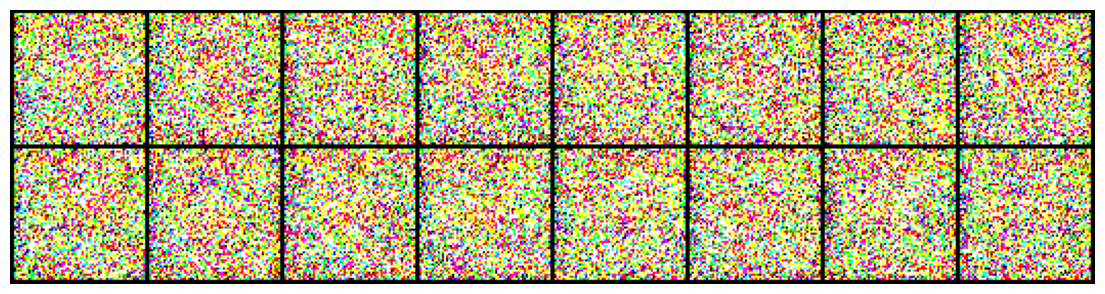

In [25]:
import matplotlib.pyplot as plt
from warnings import simplefilter

simplefilter("ignore", category=RuntimeWarning)

dataset = GalaxyDataset(images[:16], labels[:16], transform)

gen_loader = torch.utils.data.DataLoader(
    dataset, batch_size=16, shuffle=False, num_workers=2
)  # just for image num

generated_images = trainer.predict(ddpm, gen_loader)[0]

image_grid = make_grid(generated_images)
# convert to numpy
ndarr = image_grid.permute(1, 2, 0).to("cpu").numpy()
# and show
image = Image.fromarray(ndarr)

fig = plt.figure(figsize=(14, 5))
plt.imshow(image)
plt.axis("off")
plt.show()

Видим, что сгенерированные изображения представляют собой шум.

Загрузим веса предобученной модели:


In [26]:
!mkdir /content/diffusion/progress
!wget -q https://ml.gan4x4.ru/msu/additions/L13/unconditioned_baseline.pt

mkdir: cannot create directory ‘/content/diffusion/progress’: File exists


In [27]:
model = UNet()
model.load_state_dict(
    torch.load("/content/unconditioned_baseline.pt", weights_only=True, map_location="cpu")
)
ddpm = DiffusionGenerativeModel(model, path)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

0it [00:00, ?it/s]

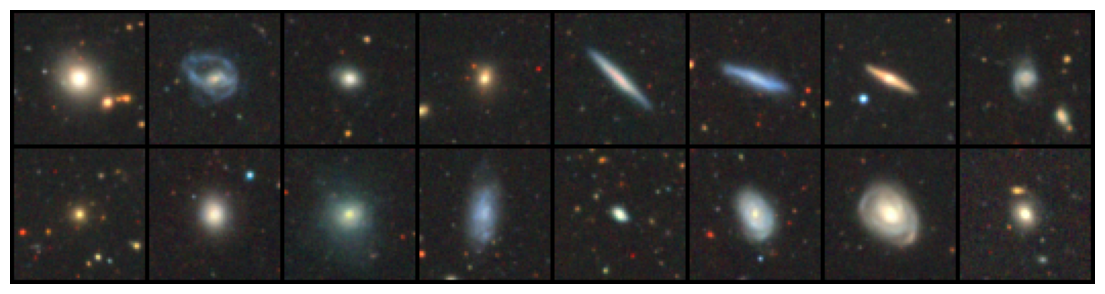

In [28]:
generated_images = trainer.predict(ddpm, gen_loader)[0]
image_grid = make_grid(generated_images)
# convert to numpy
ndarr = image_grid.permute(1, 2, 0).to("cpu").numpy()
# and show
image = Image.fromarray(ndarr)

fig = plt.figure(figsize=(14, 5))
plt.imshow(image)
plt.axis("off")
plt.show()

Понаблюдаем за процессом генерации:

In [29]:
import os
import imageio.v2 as imageio

path = Path("/content/diffusion/progress")
files = os.listdir(path)

files.sort(key=lambda x: int(x.split(".")[0]), reverse=True)

images = []
for file_name in files:
    images.append(imageio.imread(path / file_name))

imageio.mimsave("./progress.gif", images, loop=0)

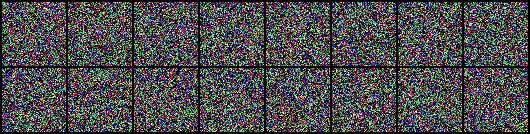

In [30]:
from IPython.display import Image, display

image = Image(filename="./progress.gif", width=1000)
display(image)